# **LOADING THE DATASET**

In [10]:
import os

# === CONFIG ===
DATA_DIR = "/kaggle/input/datasetdiabeticfootulcer/Manuallycleaned" 

# === COUNT IMAGES PER CLASS ===
for class_name in os.listdir(DATA_DIR):
    class_path = os.path.join(DATA_DIR, class_name)
    if os.path.isdir(class_path):
        num_images = len([
            f for f in os.listdir(class_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        print(f"{class_name}: {num_images} images")


Immediately_Treatable: 1827 images
no_ulcer: 924 images
Complex_Wounds: 1556 images
Treatable_Within_4_Weeks: 1940 images


# **PRE-PROCESSING**

# **GAUSSIAN BLUR**

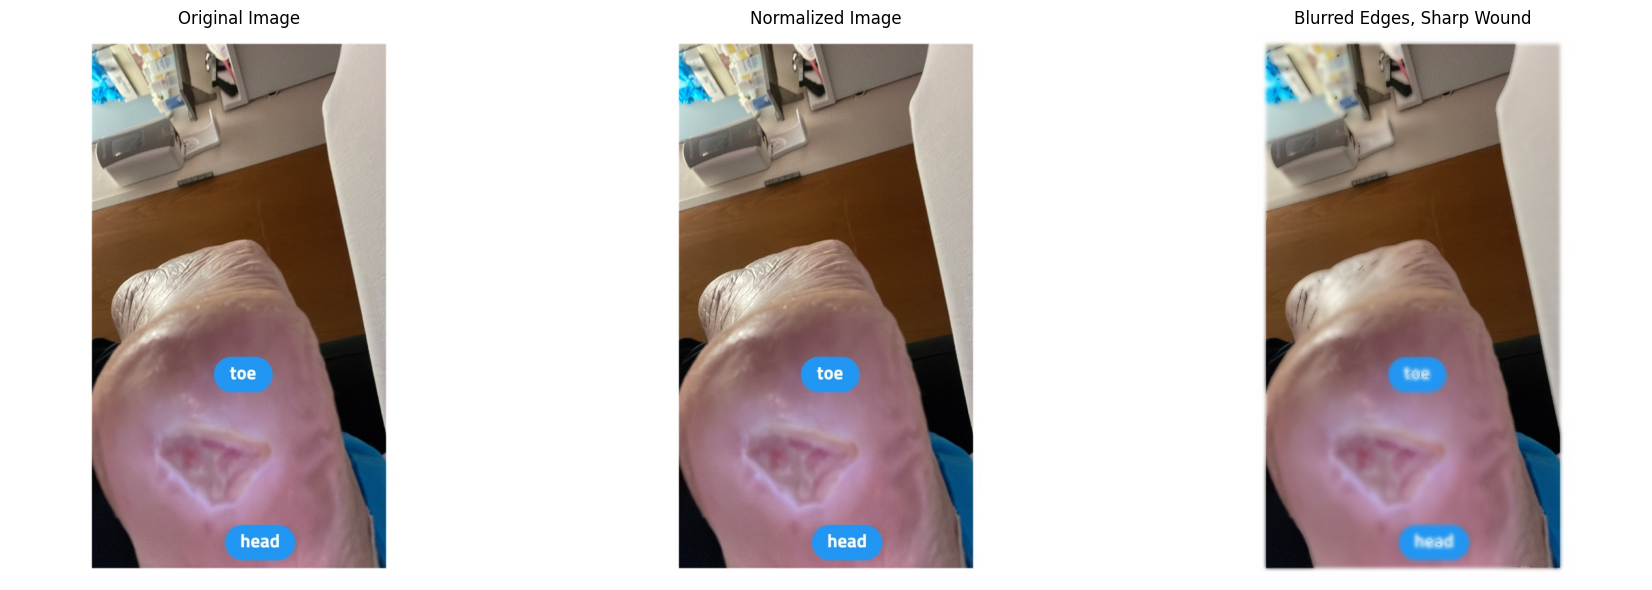

In [16]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

def load_apply_edge_blur_from_dir(directory_path):
    image_files = []

    # Gather all image paths from subdirectories
    for subdir in os.listdir(directory_path):
        subdir_path = os.path.join(directory_path, subdir)
        if os.path.isdir(subdir_path):
            image_files += [os.path.join(subdir_path, f) for f in os.listdir(subdir_path)
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print(f"No images found in directory: {directory_path}")
        return

    # Pick a random image
    random_image_path = random.choice(image_files)

    # Load the image
    img = image.load_img(random_image_path)
    img_array = img_to_array(img)

    # Convert to grayscale
    gray_img = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2GRAY)

    # Simple thresholding to detect wound area
    _, wound_mask = cv2.threshold(gray_img, 120, 255, cv2.THRESH_BINARY_INV)

    # Apply Gaussian blur
    blurred_img = cv2.GaussianBlur(img_array, (15, 15), 0)

    # Blend original wound region with blurred background
    final_img = np.where(wound_mask[..., None] == 255, img_array, blurred_img)

    # Normalize all images
    img_array_normalized = img_array / 255.0
    blurred_img_normalized = blurred_img / 255.0
    final_img_normalized = final_img / 255.0

    # Show results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(img_array.astype('uint8'))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(img_array_normalized)
    axes[1].set_title("Normalized Image")
    axes[1].axis('off')

    axes[2].imshow(final_img_normalized)
    axes[2].set_title("Blurred Edges, Sharp Wound")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Run on Kaggle dataset
dataset_path = "/kaggle/input/datasetdiabeticfootulcer/Manuallycleaned"
load_apply_edge_blur_from_dir(dataset_path)


# **SPLITTING**

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# === CONFIGURATION ===
ORIG_DIR   = "/kaggle/input/datasetdiabeticfootulcer/Manuallycleaned"                  # your input folder
WORK_DIR   = "/kaggle/working/DFU_Preprocessed"    # where splits & gens live
IMG_SIZE   = (456, 456)    # EfficientNetB5 input resolution
BATCH_SIZE = 32           # adjust if you hit OOM
VAL_RATIO  = 0.10
TEST_RATIO = 0.10
RND_STATE  = 42


CLASSES = [d for d in os.listdir(ORIG_DIR) 
           if os.path.isdir(os.path.join(ORIG_DIR, d))]


for split in ("train", "val", "test"):
    for cls in CLASSES:
        os.makedirs(os.path.join(WORK_DIR, split, cls), exist_ok=True)


for cls in CLASSES:
    src_folder = os.path.join(ORIG_DIR, cls)
    all_images = [f for f in os.listdir(src_folder) 
                  if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    
    
    train_imgs, temp_imgs = train_test_split(
        all_images,
        test_size=VAL_RATIO + TEST_RATIO,
        random_state=RND_STATE,
        shuffle=True
    )
   
    val_imgs, test_imgs = train_test_split(
        temp_imgs,
        test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO),
        random_state=RND_STATE,
        shuffle=True
    )
    
   
    for split_name, img_list in zip(("train","val","test"), 
                                    (train_imgs, val_imgs, test_imgs)):
        dest_dir = os.path.join(WORK_DIR, split_name, cls)
        for fname in img_list:
            shutil.copy2(os.path.join(src_folder, fname),
                         os.path.join(dest_dir, fname))

print(f" Finished splitting into train/val/test under {WORK_DIR}")

# === 3) SET UP IMAGE DATA GENERATORS ===
# EfficientNet preprocessing: rescales and normalizes to [−1,1]
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_directory(
    os.path.join(WORK_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = datagen.flow_from_directory(
    os.path.join(WORK_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = datagen.flow_from_directory(
    os.path.join(WORK_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print(" Generators ready for EfficientNetB5 training!")

# **VISUALIZATION OF SPLITTING**

/tmp/ipykernel_35/2182983609.py:41: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


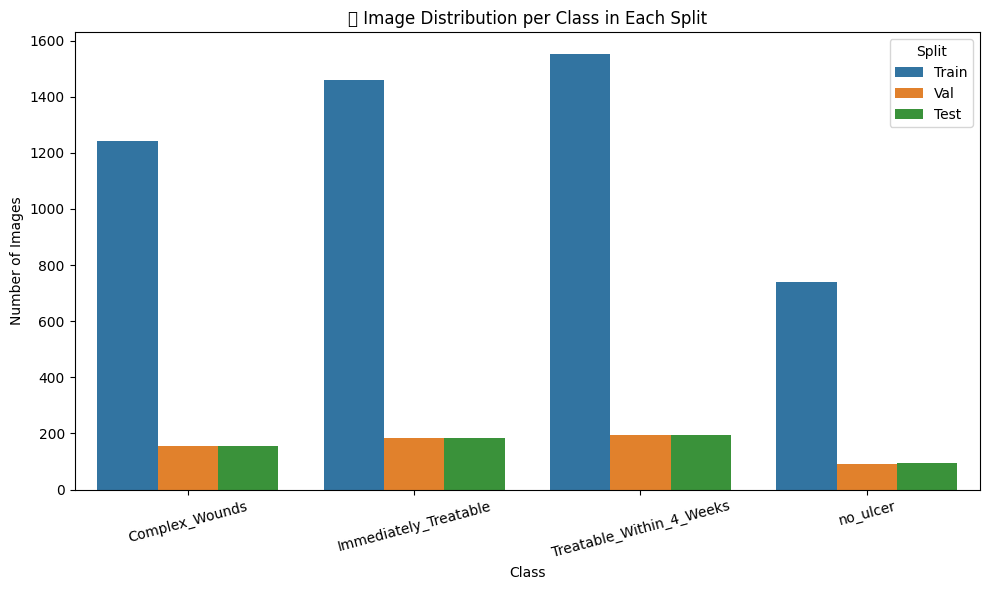

In [24]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Path to the already split dataset
base_dir = "/kaggle/input/dfu-preprocessed"
splits = ["train", "val", "test"]

# Collect image counts
data = []

for split in splits:
    split_dir = os.path.join(base_dir, split)
    if not os.path.isdir(split_dir):
        continue
    for class_name in sorted(os.listdir(split_dir)):
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        image_count = len([
            f for f in os.listdir(class_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        data.append({
            "Split": split.capitalize(),
            "Class": class_name,
            "Image Count": image_count
        })

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Class", y="Image Count", hue="Split")
plt.title("📊 Image Distribution per Class in Each Split")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


# **SEGMENTATION**

📌 Class: Complex_Wounds | File: 02adfec2-6c67-46db-98e8-213fc40a5f21.jpg.jpg


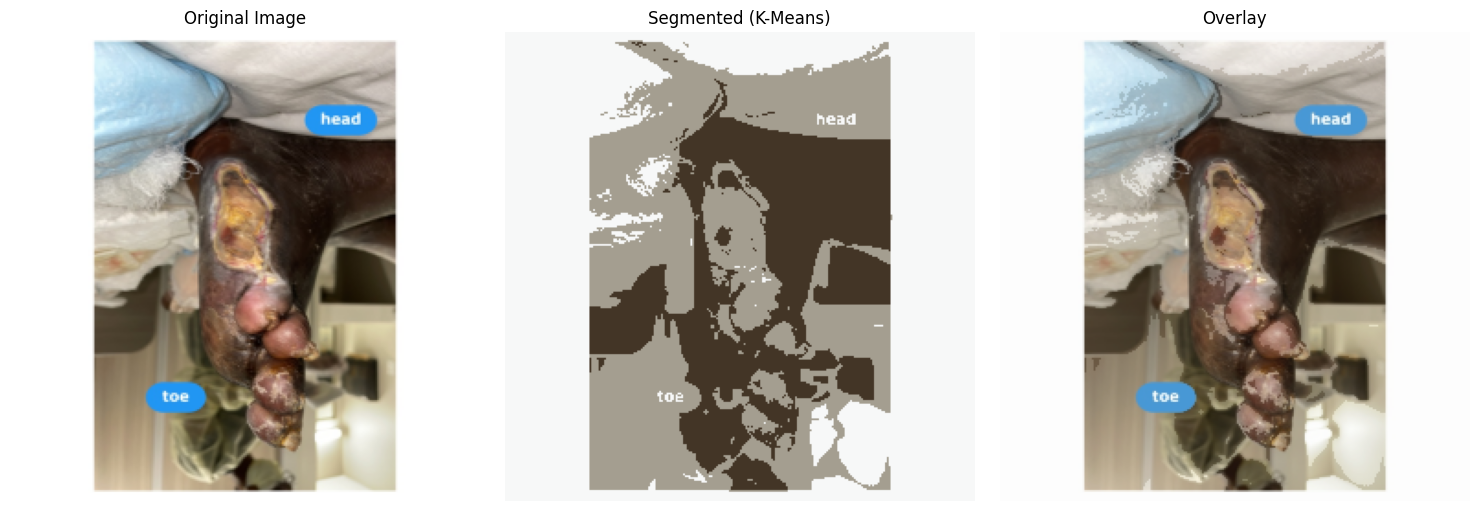

📌 Class: Complex_Wounds | File: 02adfec2-6c67-46db-98e8-213fc40a5f21.jpg_aug1.jpg


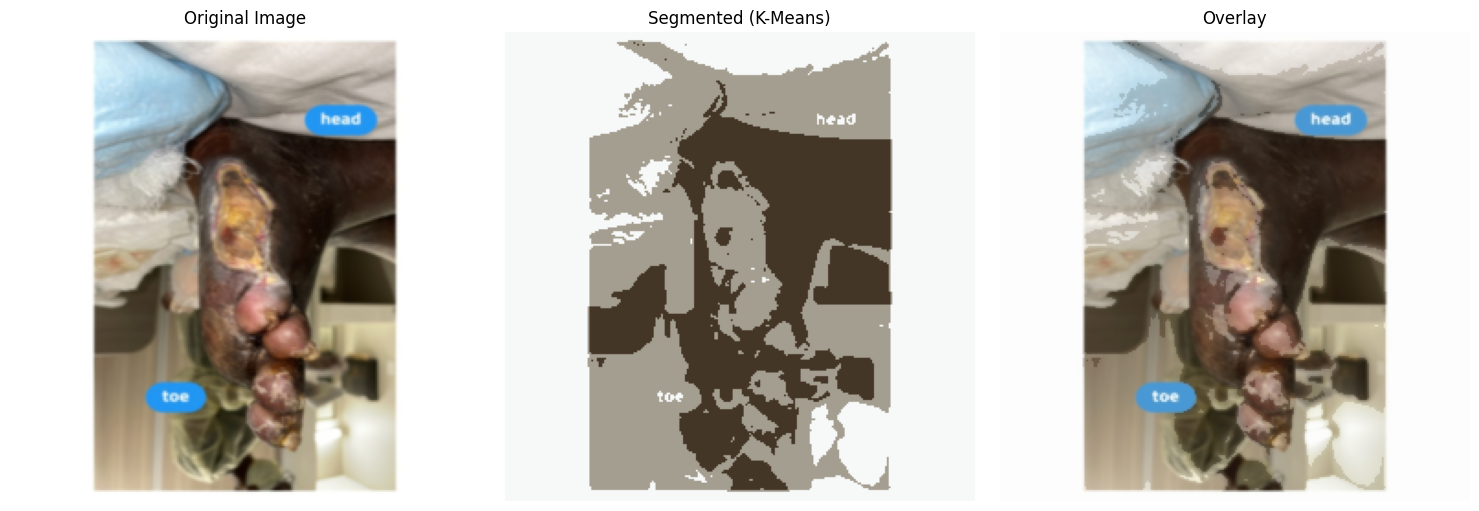

📌 Class: Complex_Wounds | File: 02adfec2-6c67-46db-98e8-213fc40a5f21.jpg_aug2.jpg


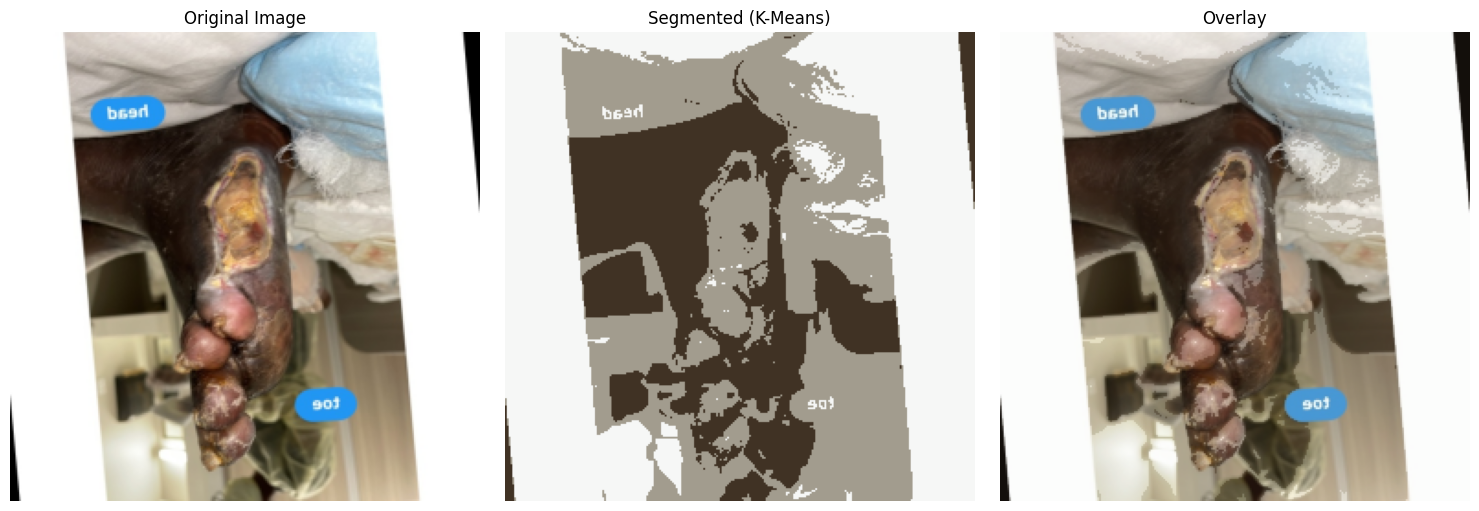

📌 Class: Complex_Wounds | File: 02adfec2-6c67-46db-98e8-213fc40a5f21.jpg_aug3.jpg


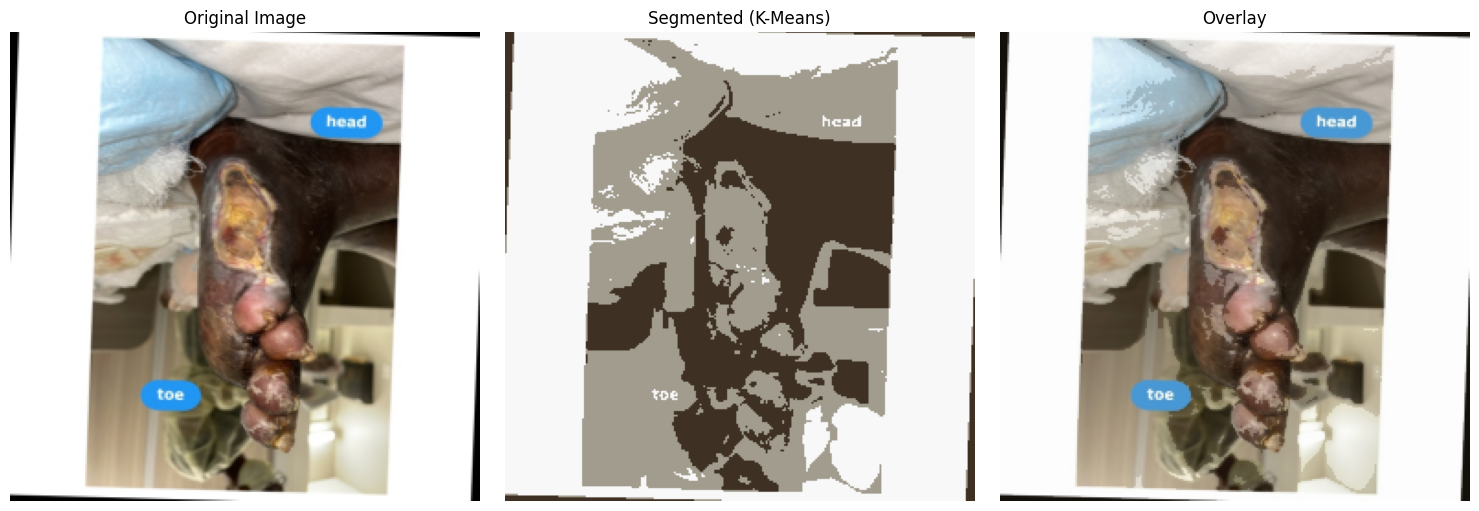

📌 Class: Complex_Wounds | File: 02adfec2-6c67-46db-98e8-213fc40a5f21.jpg_aug4.jpg


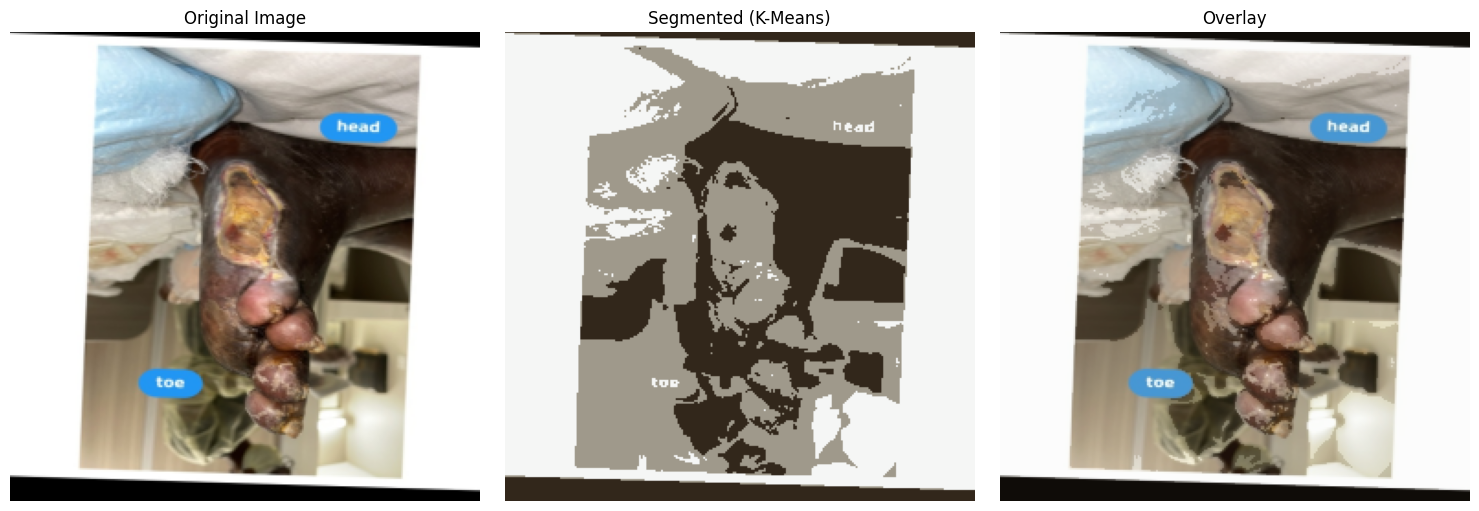

In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


data_dir = "/kaggle/input/datasetdiabeticfootulcer/Manuallycleaned"

def kmeans_segmentation_kaggle(folder_path, max_display=5):
    segmented_images = []

    count = 0
    for class_name in sorted(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in sorted(os.listdir(class_path)):
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue

            # Resize for faster processing
            img_resized = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

            # Flatten the image
            pixel_values = img_resized.reshape((-1, 3)).astype(np.float32)

            # K-means parameters
            k = 3
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

            _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
            centers = np.uint8(centers)
            segmented_img = centers[labels.flatten()].reshape(img_resized.shape)

            # Create overlay image
            overlay_img = cv2.addWeighted(img_resized, 0.7, segmented_img, 0.3, 0)

            # Store for visualization
            segmented_images.append((class_name, img_name, img_resized, segmented_img, overlay_img))
            count += 1

            if count >= max_display:
                return segmented_images

    return segmented_images

# === Run Segmentation ===
segmented_output = kmeans_segmentation_kaggle(data_dir, max_display=5)

# === Display Output ===
for label, img_name, original, segmented, overlay in segmented_output:
    print(f" Class: {label} | File: {img_name}")
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Segmented (K-Means)")
    axes[1].axis("off")

    axes[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
import shutil

shutil.make_archive("DFU_Preprocessed", 'zip', "/kaggle/working/DFU_Preprocessed")

In [ ]:
from IPython.display import FileLink
FileLink("DFU_Preprocessed.zip")

**Remove Corrupted Images from DFU Dataset**




In [ ]:
import os

def remove_bad_images(bad_images_list):
    for img_path in bad_images_list:
        try:
            os.remove(img_path)
            print(f"Deleted corrupted image: {img_path}")
        except Exception as e:
            print(f"Could not delete {img_path}: {e}")

remove_bad_images(train_bad)
remove_bad_images(val_bad)
remove_bad_images(test_bad)

# **MODEL TRAINING**

In [ ]:
import os
import shutil
import subprocess
from glob import glob


!apt-get install -y libheif-examples


INPUT_DIR = "/kaggle/input/dfu-preprocessed"
WORK_DIR = "/kaggle/working/DFU_Preprocessed"

if not os.path.exists(WORK_DIR):
    shutil.copytree(INPUT_DIR, WORK_DIR)

# === 0.3 CONVERT .HEIC.jpg FILES ===
def convert_heic_files(base_dir):
    heic_jpg_files = glob(os.path.join(base_dir, "**", "*.HEIC.jpg"), recursive=True)
    print(f"🔍 Found {len(heic_jpg_files)} suspicious HEIC.jpg files")
    for file in heic_jpg_files:
        try:
            # Rename to .HEIC
            heic_file = file.replace(".HEIC.jpg", ".HEIC")
            os.rename(file, heic_file)

            # Convert to real JPG using heif-convert
            jpg_output = file.replace(".HEIC.jpg", "_converted.jpg")
            subprocess.run(["heif-convert", heic_file, jpg_output], check=True)

            # Remove the .HEIC file after conversion
            os.remove(heic_file)
            print(f" Converted and fixed: {jpg_output}")
        except Exception as e:
            print(f" Failed to fix {file}: {e}")

convert_heic_files(WORK_DIR)

# === 1. IMPORTS ===
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# === 2. CONFIGURATION ===
IMG_SIZE    = (456, 456)
BATCH_SIZE  = 32
EPOCHS      = 50
LEARNING_RATE = 1e-4

train_dir = os.path.join(WORK_DIR, "train")
val_dir   = os.path.join(WORK_DIR, "val")
test_dir  = os.path.join(WORK_DIR, "test")

NUM_CLASSES = len(os.listdir(train_dir))

# === 3. MODEL ===
base_model = EfficientNetB5(
    include_top=False,
    input_shape=(*IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False  # freeze backbone

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# === 4. DATA GENERATORS ===
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# === 5. CALLBACKS ===
checkpoint_path = "/kaggle/working/best_model.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True)
]

# === 6. TRAIN MODEL (initial only) ===
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# === 7. EVALUATE ON TEST SET ===
test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_gen)
print(f"\n Final test accuracy: {test_acc:.4f}")
print(f" Model saved to: {checkpoint_path}")


# **Single Image Predictions using Trained EfficientNetB5 DFU Classifier**

**Predict DFU Class for a Treatable within 4 weeks Test Image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


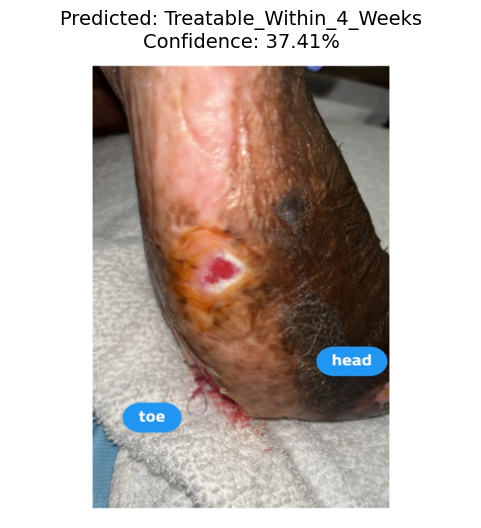

In [43]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# === CONFIGURATION ===
MODEL_PATH = "/kaggle/input/best-model/best_model.h5"
IMAGE_PATH = "/kaggle/input/dfu-preprocessed/test/Treatable_Within_4_Weeks/0d3b2192-3c37-4185-b0d9-14c16fbed43a.jpg.jpg"
IMG_SIZE = (456, 456)
CLASS_NAMES = sorted(os.listdir("/kaggle/input/dfu-preprocessed/test"))

# === LOAD MODEL ===
model = tf.keras.models.load_model(MODEL_PATH)

# === LOAD AND PREPROCESS IMAGE ===
img = Image.open(IMAGE_PATH).convert("RGB").resize(IMG_SIZE)
img_array = tf.keras.applications.efficientnet.preprocess_input(np.array(img))
img_array = np.expand_dims(img_array, axis=0)

# === PREDICT ===
pred = model.predict(img_array)
pred_class = CLASS_NAMES[np.argmax(pred)]
confidence = np.max(tf.nn.softmax(pred)) * 100

# === DISPLAY IMAGE AND PREDICTION ===
plt.figure(figsize=(6, 6))
plt.imshow(np.array(img))
plt.axis('off')
plt.title(f"Predicted: {pred_class}\nConfidence: {confidence:.2f}%", fontsize=14)
plt.show()


****Predict DFU Class for Complex Test Image****

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


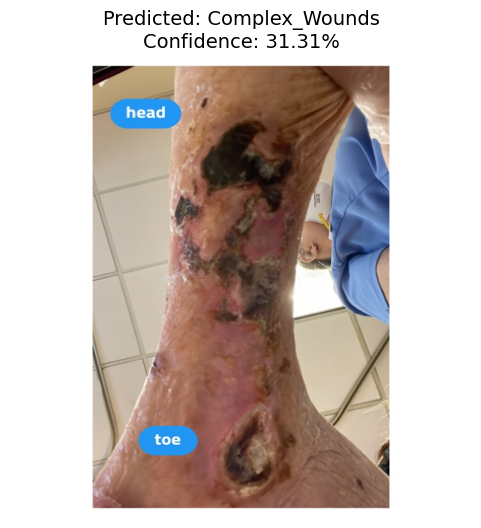

In [44]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# === CONFIGURATION ===
MODEL_PATH = "/kaggle/input/best-model/best_model.h5"
IMAGE_PATH = "/kaggle/input/dfu-preprocessed/test/Complex_Wounds/08036503-1631-4c91-be2e-f087a087f54a.jpg.jpg"
IMG_SIZE = (456, 456)
CLASS_NAMES = sorted(os.listdir("/kaggle/input/dfu-preprocessed/test"))

# === LOAD MODEL ===
model = tf.keras.models.load_model(MODEL_PATH)

# === LOAD AND PREPROCESS IMAGE ===
img = Image.open(IMAGE_PATH).convert("RGB").resize(IMG_SIZE)
img_array = tf.keras.applications.efficientnet.preprocess_input(np.array(img))
img_array = np.expand_dims(img_array, axis=0)

# === PREDICT ===
pred = model.predict(img_array)
pred_class = CLASS_NAMES[np.argmax(pred)]
confidence = np.max(tf.nn.softmax(pred)) * 100

# === DISPLAY IMAGE AND PREDICTION ===
plt.figure(figsize=(6, 6))
plt.imshow(np.array(img))
plt.axis('off')
plt.title(f"Predicted: {pred_class}\nConfidence: {confidence:.2f}%", fontsize=14)
plt.show()


**Predict DFU Class for Immediately Treatable Ulcer Test Image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


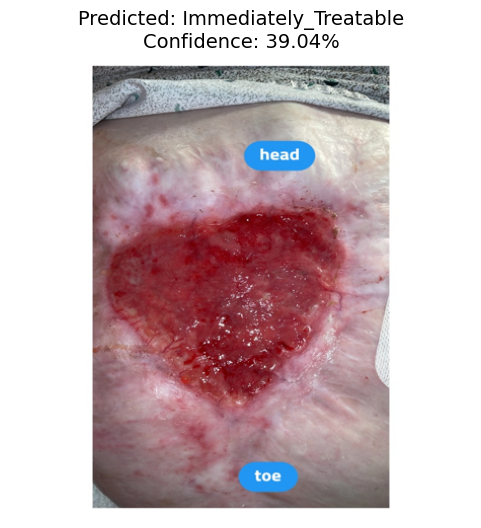

In [47]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# === CONFIGURATION ===
MODEL_PATH = "/kaggle/input/best-model/best_model.h5"
IMAGE_PATH = "/kaggle/input/dfu-preprocessed/test/Immediately_Treatable/02c635a7-ab85-4496-8f9d-efa585cbf847.jpg.jpg"
IMG_SIZE = (456, 456)
CLASS_NAMES = sorted(os.listdir("/kaggle/input/dfu-preprocessed/test"))

# === LOAD MODEL ===
model = tf.keras.models.load_model(MODEL_PATH)

# === LOAD AND PREPROCESS IMAGE ===
img = Image.open(IMAGE_PATH).convert("RGB").resize(IMG_SIZE)
img_array = tf.keras.applications.efficientnet.preprocess_input(np.array(img))
img_array = np.expand_dims(img_array, axis=0)

# === PREDICT ===
pred = model.predict(img_array)
pred_class = CLASS_NAMES[np.argmax(pred)]
confidence = np.max(tf.nn.softmax(pred)) * 100

# === DISPLAY IMAGE AND PREDICTION ===
plt.figure(figsize=(6, 6))
plt.imshow(np.array(img))
plt.axis('off')
plt.title(f"Predicted: {pred_class}\nConfidence: {confidence:.2f}%", fontsize=14)
plt.show()


**Predict DFU Class for No Ulcer Test Image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


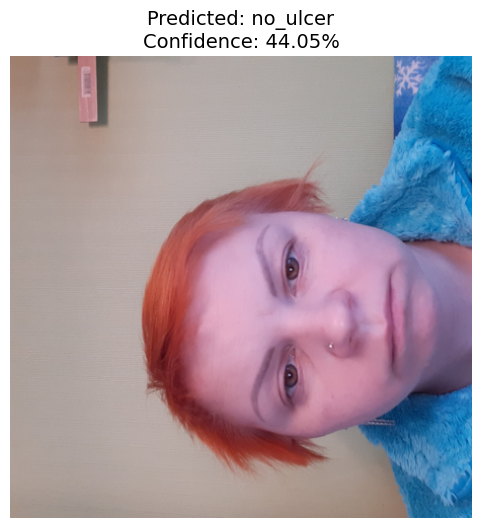

In [52]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt


MODEL_PATH = "/kaggle/input/best-model/best_model.h5"
IMAGE_PATH = "/kaggle/input/dfu-preprocessed/test/no_ulcer/060040_4_015000_FEMALE_39.jpg"
IMG_SIZE = (456, 456)
CLASS_NAMES = sorted(os.listdir("/kaggle/input/dfu-preprocessed/test"))


model = tf.keras.models.load_model(MODEL_PATH)


img = Image.open(IMAGE_PATH).convert("RGB").resize(IMG_SIZE)
img_array = tf.keras.applications.efficientnet.preprocess_input(np.array(img))
img_array = np.expand_dims(img_array, axis=0)


pred = model.predict(img_array)
pred_class = CLASS_NAMES[np.argmax(pred)]
confidence = np.max(tf.nn.softmax(pred)) * 100


plt.figure(figsize=(6, 6))
plt.imshow(np.array(img))
plt.axis('off')
plt.title(f"Predicted: {pred_class}\nConfidence: {confidence:.2f}%", fontsize=14)
plt.show()


# **FINE TUNING MODEL**

In [ ]:
import os
import shutil
from PIL import Image

input_dir = "/kaggle/input/preprocesseddfu"
output_dir = "/kaggle/working/clean-dataset"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for root, dirs, files in os.walk(input_dir):
    # Get class name from subfolder (if using class-wise folders)
    rel_path = os.path.relpath(root, input_dir)
    dest_dir = os.path.join(output_dir, rel_path)
    os.makedirs(dest_dir, exist_ok=True)

    for file in files:
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            full_path = os.path.join(root, file)
            dest_path = os.path.join(dest_dir, file)
            try:
                img = Image.open(full_path)
                img.verify()  # Validate
                shutil.copy2(full_path, dest_path)
            except Exception as e:
                print(f"Skipping corrupted file: {full_path}")


**Fine-Tune EfficientNetB5 on Clean DFU Dataset**

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt


IMG_SIZE = (456, 456)
BATCH_SIZE = 32
FINE_TUNE_EPOCHS = 30
FINE_TUNE_LR = 1e-5

train_dir = "/kaggle/working/clean-dataset/train"
val_dir   = "/kaggle/working/clean-dataset/val"
test_dir  = "/kaggle/working/clean-dataset/test"

NUM_CLASSES = len(os.listdir(train_dir))


model_path = "/kaggle/input/modeldfu/best_model.h5"
model = tf.keras.models.load_model(model_path)
print(f" Loaded model from: {model_path}")


base_model = model.get_layer(index=0)


train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)


class_counts = {
    'Immediately_Treatable':       1827,
    'No_Ulcer':                     924,
    'Complex_Wounds':              1556,
    'Treatable_Within_4_Weeks':    1940
}
class_labels = np.array(list(class_counts.keys()))
class_samples = np.array(list(class_counts.values()))

weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=np.repeat(class_labels, class_samples)
)

class_weight_dict = {
    idx: float(weights[idx])
    for idx in range(NUM_CLASSES)
}
print(f" Class weights: {class_weight_dict}")



base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=FINE_TUNE_LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


print(" Model Summary:")
model.summary()
print(f" Trainable layers: {np.sum([layer.trainable for layer in model.layers])}")


checkpoint_path = "/kaggle/working/best_model_finetuned.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    save_best_only=True,
                    monitor="val_accuracy",
                    mode="max"),
    EarlyStopping(monitor="val_accuracy",
                  patience=10,
                  restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_accuracy",
                      factor=0.5,
                      patience=5,
                      min_lr=1e-6)
]



fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weight_dict  
)



test_gen = val_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_gen)
print(f"\n Final test accuracy: {test_acc:.4f}")


final_model_path = "/kaggle/working/final__model.keras"
model.save(final_model_path)
print(f" Fine-tuned model saved to: {final_model_path}")


os.system(f"ls -lh {final_model_path}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


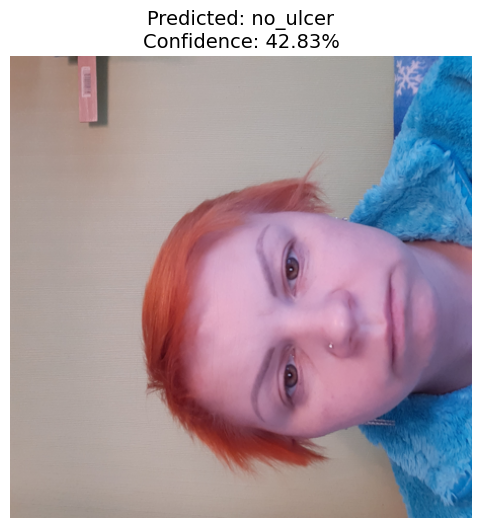

In [53]:
import tensorflow as tf
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt


CONFIG_PATH = "/kaggle/input/finetuned-model/config.json"
WEIGHTS_PATH = "/kaggle/input/finetuned-model/model.weights.h5"
IMAGE_PATH = "/kaggle/input/dfu-preprocessed/test/no_ulcer/060040_4_015000_FEMALE_39.jpg"
IMG_SIZE = (456, 456)
CLASS_NAMES = sorted(os.listdir("/kaggle/input/dfu-preprocessed/test"))  # Adjust if needed

# === LOAD MODEL ARCHITECTURE FROM JSON ===
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

model = tf.keras.models.model_from_json(json.dumps(config))


model.load_weights(WEIGHTS_PATH)


img = Image.open(IMAGE_PATH).convert("RGB").resize(IMG_SIZE)
img_array = tf.keras.applications.efficientnet.preprocess_input(np.array(img))
img_array = np.expand_dims(img_array, axis=0)


pred = model.predict(img_array)
pred_class = CLASS_NAMES[np.argmax(pred)]
confidence = np.max(tf.nn.softmax(pred)) * 100


plt.figure(figsize=(6, 6))
plt.imshow(np.array(img))
plt.axis('off')
plt.title(f"Predicted: {pred_class}\nConfidence: {confidence:.2f}%", fontsize=14)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


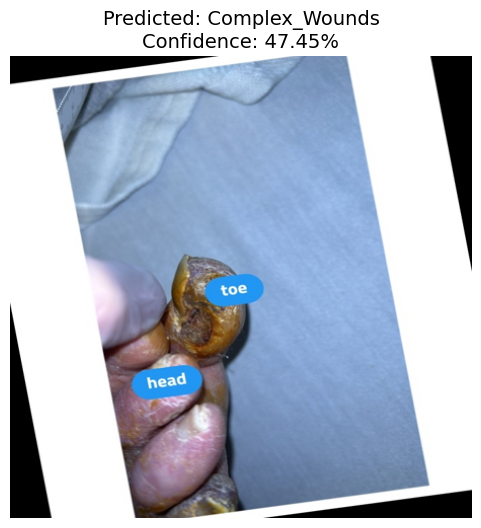

In [54]:
import tensorflow as tf
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt

# === CONFIGURATION ===
CONFIG_PATH = "/kaggle/input/finetuned-model/config.json"
WEIGHTS_PATH = "/kaggle/input/finetuned-model/model.weights.h5"
IMAGE_PATH = "/kaggle/input/dfu-preprocessed/test/Complex_Wounds/112b57e6-ae30-45c6-a0d1-a9759a4e0977.jpg_aug4.jpg"
IMG_SIZE = (456, 456)
CLASS_NAMES = sorted(os.listdir("/kaggle/input/dfu-preprocessed/test"))  # Adjust if needed

# === LOAD MODEL ARCHITECTURE FROM JSON ===
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

model = tf.keras.models.model_from_json(json.dumps(config))

# === LOAD WEIGHTS ===
model.load_weights(WEIGHTS_PATH)

# === LOAD AND PREPROCESS IMAGE ===
img = Image.open(IMAGE_PATH).convert("RGB").resize(IMG_SIZE)
img_array = tf.keras.applications.efficientnet.preprocess_input(np.array(img))
img_array = np.expand_dims(img_array, axis=0)

# === PREDICT ===
pred = model.predict(img_array)
pred_class = CLASS_NAMES[np.argmax(pred)]
confidence = np.max(tf.nn.softmax(pred)) * 100

# === DISPLAY ===
plt.figure(figsize=(6, 6))
plt.imshow(np.array(img))
plt.axis('off')
plt.title(f"Predicted: {pred_class}\nConfidence: {confidence:.2f}%", fontsize=14)
plt.show()
